# Neural Network Implementation in PyTorch

## Overview
This notebook primarily focuses on **manually implementing a neural network from scratch using PyTorch**, rather than on breast cancer detection itself.

The Breast Cancer dataset is used **only as a practical example** to demonstrate how a neural network works internally.

Instead of using high-level abstractions like `torch.nn.Module` or built-in optimizers, this notebook explicitly implements:
- Weight and bias initialization
- Forward pass using matrix multiplication
- Sigmoid activation
- Binary Cross-Entropy loss
- Backpropagation via `autograd`
- Manual gradient descent updates

The objective is to build **conceptual clarity** around:
- Tensor shapes and operations  
- Vectorized computation over all samples  
- PyTorch’s computation graph and automatic differentiation  

This notebook trains a **single-neuron (perceptron-style) neural network** using all samples simultaneously, highlighting how modern deep learning frameworks efficiently handle learning at scale.


#Data  loading and preprocessing

load  brest cancer dataset from   github   in which   there are  30  input features and  we  do   sinlge class  classification  0/1

In [6]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
df = pd.read_csv('https://raw.githubusercontent.com/gscdit/Breast-Cancer-Detection/refs/heads/master/data.csv')
df.drop(columns=['id', 'Unnamed: 32'], inplace= True)
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 1:], df.iloc[:, 0], test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

#converting  numpy array   to PyTorch Tensor

In [19]:
x_train_tensor=torch.from_numpy(X_train)      #torch.tensor(X_train)  we can also do this
x_test_tensor=torch.from_numpy(X_test)
y_train_tensor=torch.from_numpy(y_train)
y_test_tensor=torch.from_numpy(y_test)

In [78]:
print(x_train_tensor,x_train_tensor.shape)

tensor([[-1.8034,  1.3404, -1.8019,  ..., -1.7530,  0.2421,  0.7964],
        [ 1.8634, -0.3879,  1.7229,  ...,  1.1016, -0.2354,  0.2466],
        [ 0.8982,  0.5748,  0.8388,  ...,  1.2920,  0.4870, -0.4602],
        ...,
        [-1.5553,  0.3308, -1.5246,  ..., -1.3266,  0.1088, -0.3848],
        [ 2.0318,  0.7919,  1.9014,  ...,  1.3303, -0.1238, -0.4835],
        [ 0.6441, -0.8513,  0.5524,  ...,  0.3297, -0.9330, -0.6406]],
       dtype=torch.float64) torch.Size([455, 30])


### the  traning data x_train_tensor is  2d tensor  
> it is simpel mtrix of  455x30  


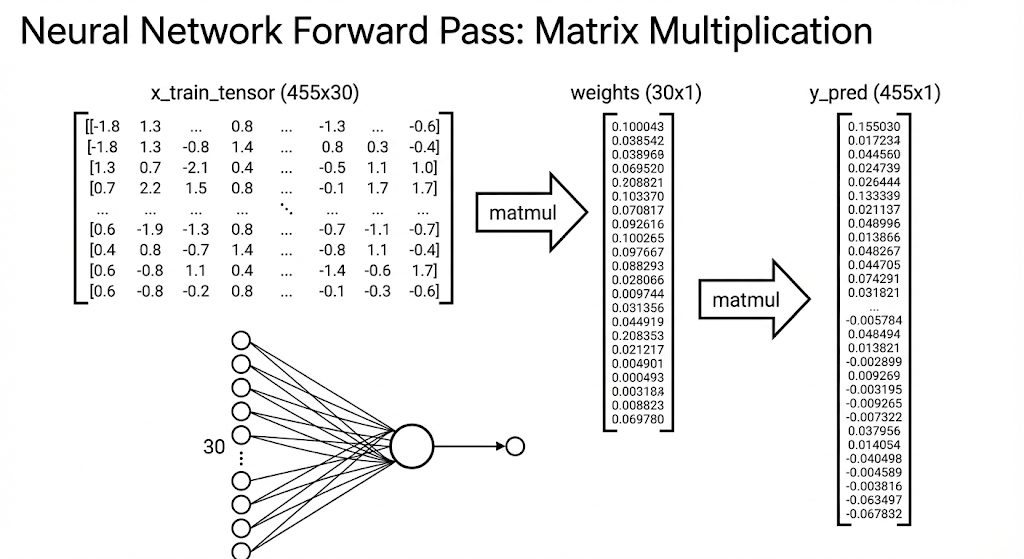



## Understanding (Refined)

> First, we convert the entire training dataset into tensors:
> `x_train_tensor` of shape **(455, 30)** and `y_train_tensor` of shape **(455, 1)**.
> Each row represents one sample, and each column represents one feature.

> Next, we define a `CustomNN` class.
> Inside this class, we create a **weight tensor** whose dimension matches the feature space (**30**), because each input feature needs one weight.
> These weights represent the connections from the input layer to a **single neuron (perceptron)**.
> We also define a **bias tensor**, which shifts the neuron’s output.

> All data is stored as tensors because tensors allow **efficient mathematical operations**.
> Instead of iterating over 455 samples, we perform a **single matrix multiplication**:
>
> ```
> (455 × 30) @ (30 × 1) → (455 × 1)
> ```
>
> This produces `y_pred`, where each value corresponds to one training sample.

> Because these operations are independent across samples, PyTorch can exploit **parallelism and GPU acceleration**, making computation much faster.

---

## Computation Graph (Key Idea)

> PyTorch automatically builds a **computation graph** during the forward pass.

* `weights` and `bias` have `requires_grad=True`
* Every operation (`matmul`, `+`, `sigmoid`, `loss`) is tracked
* The final `loss` is a **single scalar**

When you call:

```python
loss.backward()
```

PyTorch computes:

```
∂loss / ∂weights
∂loss / ∂bias
```

using the computation graph and the **chain rule**.

Then you update parameters:

```python
model.weights -= learning_rate * model.weights.grad
model.bias    -= learning_rate * model.bias.grad
```

This moves the weights and bias in the direction that **reduces the average loss over all 455 samples**.


> You train **one neuron**, using **all samples at once**, by leveraging tensors, matrix multiplication, and automatic differentiation via the computation graph.


# Defining Model

In [67]:
class CoustomNN():
  def __init__(self,x):
    self.weights=torch.rand(x.shape[1],dtype=torch.float64,requires_grad=True)  # this is  weights of   input  layer  connecting to first  nurone of network
    self.bias=torch.zeros(1,dtype=torch.float64,requires_grad=True)
  def forwardpass(self,x):
    z=torch.matmul(x,self.weights)+self.bias   #  in singel  pass  we calculate   the   ypred tensor  which  is a  vector of (455)
    return torch.sigmoid(z)
  def loss_function(self, y_pred, y):
    #Binarey cross entropey
    # Clamp predictions to avoid log(0)
    epsilon = 1e-7
    y_pred = torch.clamp(y_pred, epsilon, 1 - epsilon)
    # Calculate loss
    loss = -(y_train_tensor * torch.log(y_pred) + (1 - y_train_tensor) * torch.log(1 - y_pred)).mean()
    return loss


#Important Parameters

In [36]:
learning_rate=.1
epochs=25

#Traning Pipline


In [74]:
# create model
model=CoustomNN(x_train_tensor)
print(model.weights.shape,model.weights)
print(model.bias)

for i in range(epochs):
  #forwardPass
  y_pred=model.forwardpass(x_train_tensor)
  #calculating loss
  loss=model.loss_function(y_pred,y_train_tensor)

  #backward pass
  loss.backward()

  #weights updation
  with torch.no_grad():
    model.weights-=(learning_rate*model.weights.grad)
    model.bias-=(learning_rate*model.bias.grad)
  # to solve acumulating gradient
  model.weights.grad.zero_()
  model.bias.grad.zero_()

  #print loss in each epoch
  print(f" in epoch {i+1} loss  is {loss.item()}")






torch.Size([30]) tensor([6.4134e-01, 1.6635e-01, 8.1450e-02, 5.4037e-01, 2.5907e-01, 1.2041e-01,
        1.3270e-01, 9.1026e-01, 2.1555e-01, 8.6727e-01, 5.4327e-01, 7.2007e-01,
        1.7962e-02, 7.4997e-01, 8.9385e-01, 6.3417e-01, 6.4811e-01, 3.8814e-01,
        3.5331e-01, 1.6104e-01, 3.5870e-01, 5.4510e-01, 3.3882e-01, 5.0340e-01,
        3.9025e-01, 5.2922e-04, 9.3507e-01, 8.0330e-01, 2.8805e-01, 7.7671e-01],
       dtype=torch.float64, requires_grad=True)
tensor([0.], dtype=torch.float64, requires_grad=True)
 in epoch 1 loss  is 0.49960145769644587
 in epoch 2 loss  is 0.48715199652603497
 in epoch 3 loss  is 0.47509902317177893
 in epoch 4 loss  is 0.463429889229398
 in epoch 5 loss  is 0.45213218329758853
 in epoch 6 loss  is 0.4407313706616257
 in epoch 7 loss  is 0.4288078620310507
 in epoch 8 loss  is 0.41725431447948974
 in epoch 9 loss  is 0.40606047620591623
 in epoch 10 loss  is 0.39521717839928305
 in epoch 11 loss  is 0.3847164159327695
 in epoch 12 loss  is 0.37455132

# evaluating  trained model

In [75]:
with torch.no_grad():
  y_pred=model.forwardpass(x_test_tensor)
  y_pred=(y_pred>0.5).float()
  accuracy = (y_pred == y_test_tensor).float().mean()
  print(f'Accuracy: {accuracy.item()}')

Accuracy: 0.9210526347160339
